In [300]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pickle
import sklearn as sk
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from munkres import Munkres
import pandas as pd
from ktools import *
import igraph as ig
import leidenalg
import tqdm
from collections import defaultdict

In [301]:
res = {}


In [302]:
label_colors = {"louvain":sns.color_palette()[0],
                "leiden": sns.color_palette()[1],
                "gn":sns.color_palette()[2]}

# Importing Data

Data Set

In [303]:
def create_adjacency(df:pd.DataFrame)->np.array:
    m = max(max(df["zero"].value_counts().index), max(df["one"].value_counts().index)) + 1
    A = np.zeros((m,m))
    a,b = df["zero"].to_numpy(dtype=int), df["one"].to_numpy(dtype=int)

    A[a,b] =1
            
    return A

In [304]:
data = pd.read_csv(r"data\email-Eu-core-temporal.txt.gz")
data = data.map(str.split)
series_d, series_0,  series_1, t = data.map(lambda x:(x[0], x[1])).values.flatten(),data.map(lambda x:x[0]).values.flatten(), data.map(lambda x:x[1]).values.flatten(), data.map(lambda x:x[2]).values.flatten()

series_d = pd.Series(series_d)
wt = pd.Series(series_d).value_counts()


to_integer = np.vectorize(int)
edges = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1), "d": series_d, "w": series_d.map(lambda x: wt[x])})


edges

,zero,one,d,w
0,168,472,"(168, 472)",668
1,168,912,"(168, 912)",1212
2,2,790,"(2, 790)",229
3,2,322,"(2, 322)",10
4,2,790,"(2, 790)",229
...,...,...,...,...
332328,324,367,"(324, 367)",1
332329,790,126,"(790, 126)",150
332330,790,126,"(790, 126)",150
332331,782,126,"(782, 126)",54


In [305]:
edges

,zero,one,d,w
0,168,472,"(168, 472)",668
1,168,912,"(168, 912)",1212
2,2,790,"(2, 790)",229
3,2,322,"(2, 322)",10
4,2,790,"(2, 790)",229
...,...,...,...,...
332328,324,367,"(324, 367)",1
332329,790,126,"(790, 126)",150
332330,790,126,"(790, 126)",150
332331,782,126,"(782, 126)",54


In [306]:
#handling the edges
data = pd.read_csv(r"data\email-Eu-core.txt.gz")
data = data.map(str.split)
series_0 = data.map(lambda x:x[0]).values.flatten()
series_1 = data.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)


df = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1)})
df = df.dropna()
df

,zero,one
0,2,3
1,2,4
2,5,6
3,5,7
4,8,9
...,...,...
25565,420,143
25566,174,859
25567,440,460
25568,52,786


In [307]:
# Handling the Labels
labels = pd.read_csv(r"data\email-Eu-core-department-labels.txt.gz")

labels= labels.map(str.split)
series_0 = labels.map(lambda x:x[0]).values.flatten()
series_1 = labels.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)
labels = pd.DataFrame({"node": to_integer(series_0), "label": to_integer(series_1)})
labels = labels.dropna()

In [308]:
comms = {label: list(labels[labels["label"] == label]["node"]) for label in labels["label"].unique()}
labels["community"] = labels["label"].map(comms)

In [309]:
A = create_adjacency(df)
eucore = nx.from_numpy_array(A)
nx.set_node_attributes(eucore, labels["community"], "community")
eucore.remove_node(1004)

Random Networks


In [310]:
def import_random_state():
    random_state_integers = np.loadtxt("random_state_integers.txt")
    enc="MT19937"
    params = []
    with open(r'random_state_params.txt', 'r') as fp:
        for line in fp:
            # remove linebreak from a current name
            # linebreak is the last character of each line
            x = line[:-1]

            # add current item to the list
            params.append(x)

    params[0] = int(params[0])
    params[1] = int(params[1])
    params[2] = float(params[2])

    params.insert(0,enc)
    params.insert(1, random_state_integers)
    
    return tuple(params)

In [311]:
np.random.set_state(import_random_state())

In [312]:
G_small = pickle.load(open('small50.pickle', 'rb'))

In [313]:
G_medium = pickle.load(open('medium250.pickle', 'rb'))

In [314]:
G_large = pickle.load(open('large250.pickle', 'rb'))

In [315]:
def create_gcl(G):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    # ----------------------------- generating_labels ---------------------------- #
    ground_community_labels = {}
    counter =0

    for i in ground:
        if i not in ground_community_labels:
            ground_community_labels[i] = counter
            counter += 1

    gcl = [ground_community_labels[frozenset(G.nodes[node]["community"])]  for node in G.nodes]

    return gcl

In [316]:
def create_lcl(comms,G):
    """create labels for the outcome communities commmunties
    """
    counter = 0    
    community_dict = {}
    for i in comms:
        if i not in community_dict:
            community_dict[i] = counter
        counter += 1

    lcl = []
    for node in G.nodes:
        c = [x for x in comms if node in x]
        c = c[0]
        lcl.append(community_dict[c])

    return lcl

# Creating Baselines

### Baseline Louvain

In [317]:
def baseline_metrics_louvain(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    gcl = create_gcl(G)

    generated_communities = [nx.community.louvain_communities(G, weight=None) for _ in range(n)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(n):
        counter =0
        comms = nx.community.louvain_communities(G)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    return stats_dict

In [318]:
res["louvain_small"] =baseline_metrics_louvain(G_small)
res["louvain_small"]

{'a_modularity': 0.22040372463510147,
 'var_modularity': 7.341418713230742e-05,
 'a_nmi': 0.406818467214035,
 'var_nmi': 0.0029729149646155356,
 'a_kappa': 0.21489653562151592,
 'var_kappa': 0.03167928754064294,
 'accuracy': 0.2332045295682035}

In [319]:
res["louvain_medium"] = baseline_metrics_louvain(G_medium)

In [320]:
res["louvain_large"] = baseline_metrics_louvain(G_large)

In [321]:
res["louvain_eucore"] = baseline_metrics_louvain(eucore)

### Baseline Leiden

In [322]:
def run_leiden(G):
    """"Runs the Leidein Algorithm in a graph G"""
    h = ig.Graph.from_networkx(G)
    partition = leidenalg.find_partition(h, leidenalg.ModularityVertexPartition, weights="weight")
    communities = [[] for _ in range(len(partition))]
    # Fill the communities with vertex indices
    for vertex, community in enumerate(partition.membership):
        communities[community].append(vertex)

    return communities    

In [323]:
def baseline_metrics_leiden(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    gcl = create_gcl(G)

    generated_communities = [run_leiden(G) for _ in range(10)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []


    for _ in range(n):
        counter =0
        comms = run_leiden(G)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 


    return stats_dict



In [324]:
res["leiden_small"] = baseline_metrics_leiden(G_small)

In [325]:
res["leiden_medium"] = baseline_metrics_leiden(G_medium)

In [326]:
res["leiden_large"] = baseline_metrics_leiden(G_large)

c:\Users\Felipe Cintra\Documents\TUE_2324\JBG-100 BEP\Code2\.venv\Lib\site-packages\leidenalg\VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
c:\Users\Felipe Cintra\Documents\TUE_2324\JBG-100 BEP\Code2\.venv\Lib\site-packages\leidenalg\VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.


KeyError: 'Attribute does not exist'

In [ ]:
res["leiden_eucore"] = baseline_metrics_leiden(eucore)

### Baseline GN

In [ ]:
# nx.community.girvan_newman(G_medium)
# comp = nx.community.girvan_newman(G_large)
# gn = tuple(sorted(c) for c in next(comp))

# gn_communities = {}

# for communities in tqdm.tqdm(np.itertools.islice(comp, 3)):
#     print(tuple(sorted(c) for c in communities))

In [ ]:
def baseline_metrics_gn(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}
    
    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    ground_community_labels = {}
    counter =0

    for i in ground:
        if i not in ground_community_labels:
            ground_community_labels[i] = counter
            counter += 1

    gcl = [ground_community_labels[frozenset(G.nodes[node]["community"])]  for node in G.nodes]
    
    nx.community.girvan_newman(G)
    comp = nx.community.girvan_newman(G)
    gn = tuple(sorted(c) for c in next(comp))

    generated_communities = [{frozenset(c) for c in gn}] 
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    
    comms = frozenset(generated_communities[0]) 
    counter = 0


    community_dict = {}
    for i in comms:
        if i not in community_dict:
            community_dict[i] = counter
        counter += 1

    lcl = []
    for node in G.nodes:
        c = [x for x in comms if node in x]
        c = c[0]
        lcl.append(community_dict[c])

    l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

    #calculating kappa   
    l_kappa.append(total_kappa(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 


    return stats_dict

In [ ]:
res["gn_small"] = baseline_metrics_gn(G_small)

In [ ]:
res["gn_medium"] = baseline_metrics_gn(G_medium)


In [ ]:
res["gn_large"] =  baseline_metrics_gn(G_medium)

In [ ]:
# res["gn_eucore"] = baseline_metrics_gn(eucore)

In [ ]:
modularities = [res[key]["a_modularity"] for key in res ]
nmis = [res[key]["a_nmi"] for key in res ]
kappas = [res[key]["a_kappa"] for key in res ]



colors = [label_colors[str(key).split("_")[0]] for key in res]
res.keys()


dict_keys(['louvain_small', 'louvain_medium', 'louvain_large', 'louvain_eucore', 'leiden_small', 'leiden_medium', 'leiden_large', 'leiden_eucore', 'gn_small', 'gn_medium', 'gn_large'])

C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_21500\2088141532.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_21500\2088141532.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_21500\2088141532.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")


Text(0.5, 0.98, 'Performance Metrics of Baseline Algorithms')

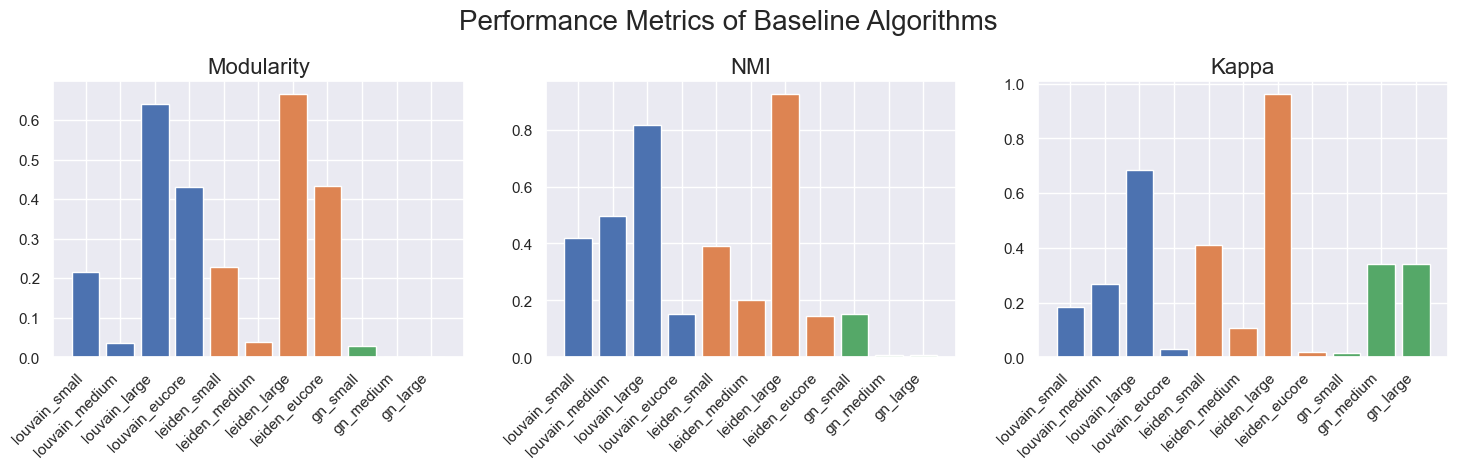

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

# modularity
ax[0].bar([key for key in res], modularities, color=colors)
ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[0].set_title("Modularity", fontsize=16)


# nmi
ax[1].bar([key for key in res], nmis, color=colors)
ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[1].set_title("NMI", fontsize=16)

# kappa
ax[2].bar([key for key in res], kappas, color=colors)
ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[2].set_title("Kappa", fontsize=16)

plt.subplots_adjust(top=0.8)
plt.suptitle("Performance Metrics of Baseline Algorithms", fontsize=20)


In [ ]:
res_flow_capacity = {}
alpha_mod = {}

In [ ]:
def flow_capacity_louvain_mod(G, quality="m"):
    metrics = []
    alpha_vals = np.arange(0,1, 0.1)
    gcl = create_gcl(G)
    
    for alpha in alpha_vals: #training
        A = nx.adjacency_matrix(G, weight=None)
        I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
        F = (1-alpha)*A + alpha*I
        F = nx.from_numpy_array(F)
        # ---------------------------------- running algorithm --------------------------------- #

 
        generated_communities = [nx.community.louvain_communities(F, weight="weight") for _ in tqdm.tqdm(range(5))]


        if quality == "m":   # metric = modularity
            metrics.append(np.mean([nx.community.modularity(G,c) for c in generated_communities]))

        else:
            l = []

            for comms in generated_communities:
                comms = [frozenset(i) for i in comms]
                lcl = create_lcl(comms,G)

                if quality == "n":
                    l.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl)) # metric nmi
                else:
                    l.append(total_kappa(gcl, lcl)) # metric kappa

            metrics.append(np.mean(l)) 



    # ------------------------- applying trained version ------------------------- #

    alpha_index, max_metric = metrics.index(max(metrics)), max(metrics) #gets index with highest alpha value, gets highest metric value
    max_alpha = alpha_vals[alpha_index]

    I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
    F = (1-max_alpha)*A + max_alpha*I
    
    F = nx.from_numpy_array(F)

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #


    generated_communities = [nx.community.louvain_communities(F) for _ in range(10)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(15):
        counter =0
        comms = nx.community.louvain_communities(F)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    
    return stats_dict, max_alpha, metrics

In [ ]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_small, quality="q")
res_flow_capacity["louvain_small_modularity"] =  stats
alpha_mod["louvain_small_modularity"] = [alpha, max_mod]

100%|██████████| 5/5 [00:00<00:00, 306.09it/s]


In [ ]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_small, quality="k")
res_flow_capacity["louvain_small_kappa"] =  stats
alpha_mod["louvain_small_kappa"] = [alpha, max_mod]

100%|██████████| 5/5 [00:00<00:00, 254.84it/s]


In [ ]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_medium, quality="q")
res_flow_capacity["louvain_medium_nmi"] =  stats
alpha_mod["louvain_medium_nmi"] = [alpha, max_mod]


100%|██████████| 5/5 [00:00<00:00,  7.35it/s]


In [ ]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_medium, quality="k")
res_flow_capacity["louvain_medium_kappa"] =  stats
alpha_mod["louvain_medium_kappa"] = [alpha, max_mod]

100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


In [ ]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_medium, quality="n")
res_flow_capacity["louvain_medium_nmi"] =  stats
alpha_mod["louvain_medium_nmi"] = [alpha, max_mod]

100%|██████████| 5/5 [00:00<00:00,  7.04it/s]


In [ ]:
stats, alpha, max_mod = flow_capacity_louvain_mod(eucore, quality="k")
res_flow_capacity["louvain_eucore_kappa"] =  stats
alpha_mod["louvain_eucore_kappa"] = [alpha, max_mod]

stats, alpha, max_mod

100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


({'a_modularity': 0.4308130792771318,
  'var_modularity': 1.8394878158785198e-06,
  'a_nmi': 0.1477209090801545,
  'var_nmi': 2.5963420709214128e-05,
  'a_kappa': 0.02864192972533468,
  'var_kappa': 0.00044487958137153324,
  'accuracy': 0.008358172057729988},
 0.9,
 [0.019715108422488158,
  0.021913504713487676,
  0.02291277575485109,
  0.02171365050521499,
  0.02051452525557889,
  0.01751671213148864,
  0.024711463629305243,
  0.021313942088669623,
  0.02710971412857744,
  0.02990767304439501])

In [ ]:
stats, alpha, max_mod = flow_capacity_louvain_mod(eucore, quality="q")
res_flow_capacity["louvain_eucore_modularity"] =  stats
alpha_mod["louvain_eucore_modularity"] = [alpha, max_mod]


stats, alpha, max_mod

100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


({'a_modularity': 0.43114144162621704,
  'var_modularity': 2.375417023144583e-06,
  'a_nmi': 0.15143572090562737,
  'var_nmi': 4.9898759561503614e-05,
  'a_kappa': 0.01778318440918555,
  'var_kappa': 0.00015090863577827716,
  'accuracy': 0.006928307673612401},
 0.0,
 [0.02830883937821354,
  0.018316128964579372,
  0.013119919549489606,
  0.011920794299853505,
  0.025510880462395975,
  0.021114087880396943,
  0.01931540000594279,
  0.02351233837966914,
  0.019315400005942795,
  0.023112629963123778])

In [ ]:
stats, alpha, max_mod = flow_capacity_louvain_mod(eucore, quality="n")
res_flow_capacity["louvain_eucore_nmi"] =  stats
alpha_mod["louvain_eucore_nmi"] = [alpha, max_mod]

stats, alpha, max_mod

100%|██████████| 5/5 [00:01<00:00,  4.46it/s]


({'a_modularity': 0.43058284141798236,
  'var_modularity': 3.5685827187667446e-06,
  'a_nmi': 0.14926550816525747,
  'var_nmi': 6.960603101801811e-05,
  'a_kappa': 0.01931540000594279,
  'var_kappa': 0.000286754810968639,
  'accuracy': 0.006305525224661249},
 0.8,
 [0.14815605804770288,
  0.15035568266637397,
  0.1472154105086003,
  0.14983891049520387,
  0.14962287799007928,
  0.14655355362816508,
  0.14731526744071413,
  0.14576277614069072,
  0.1509386988777087,
  0.14421120943644344])

In [ ]:
d = {0.1:1, 0.2:5, 0.3:4, 0.4:1}


In [330]:
def flow_capacity_leiden(G, quality="m"):
    metrics = []
    alpha_vals = np.arange(0,1, 0.1)
    gcl = create_gcl(G)
    
    for alpha in alpha_vals: #training
        A = nx.adjacency_matrix(G, weight=None)
        I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
        F = (1-alpha)*A + alpha*I
        F = nx.from_numpy_array(F)
        # ---------------------------------- running algorithm --------------------------------- #

 
        generated_communities = [run_leiden(F) for _ in tqdm.tqdm(range(10))]


        if quality == "m":   # metric = modularity
            metrics.append(np.mean([nx.community.modularity(G,c) for c in generated_communities]))

        else:
            l = []

            for comms in generated_communities:
                comms = [frozenset(i) for i in comms]
                lcl = create_lcl(comms,G)

                if quality == "n":
                    l.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl)) # metric nmi
                else:
                    l.append(total_kappa(gcl, lcl)) # metric kappa

            metrics.append(np.mean(l)) 



    # ------------------------- applying trained version ------------------------- #

    alpha_index, max_metric = metrics.index(max(metrics)), max(metrics) #gets index with highest alpha value, gets highest metric value
    max_alpha = alpha_vals[alpha_index]

    I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
    F = (1-max_alpha)*A + max_alpha*I
    
    F = nx.from_numpy_array(F)

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #


    generated_communities = [run_leiden(F) for _ in tqdm.tqdm(range(10))]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(15):
        counter =0
        comms = nx.community.louvain_communities(F)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    
    return stats_dict, max_alpha, metrics

In [334]:
stats, alpha, max_mod = flow_capacity_leiden(G_small, quality="q")
res_flow_capacity["leiden_small_modularity"] =  stats
alpha_mod["leiden_small_modularity"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 833.13it/s]


100%|██████████| 10/10 [00:00<00:00, 1139.32it/s]


In [338]:
stats, alpha, max_mod = flow_capacity_leiden(G_medium, quality="q")
res_flow_capacity["leiden_medium_modularity"] =  stats
alpha_mod["leiden_medium_modularity"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 37.85it/s]


In [339]:
stats, alpha, max_mod = flow_capacity_leiden(eucore, quality="q")
res_flow_capacity["leiden_eucore_modularity"] =  stats
alpha_mod["leiden_eucore_modularity"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 25.87it/s]


In [341]:
stats, alpha, max_mod = flow_capacity_leiden(G_small, quality="k")
res_flow_capacity["leiden_small_kappa"] =  stats
alpha_mod["leiden_small_kappa"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 833.08it/s]


100%|██████████| 10/10 [00:00<00:00, 565.43it/s]


In [342]:
stats, alpha, max_mod = flow_capacity_leiden(G_medium, quality="k")
res_flow_capacity["leiden_medium_kappa"] =  stats
alpha_mod["leiden_medium_kappa"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 39.46it/s]


In [343]:
stats, alpha, max_mod = flow_capacity_leiden(eucore, quality="k")
res_flow_capacity["leiden_eucore_kappa"] =  stats
alpha_mod["leiden_eucore_kappa"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 23.47it/s]


In [344]:
stats, alpha, max_mod = flow_capacity_leiden(G_small, quality="n")
res_flow_capacity["leiden_small_nmi"] =  stats
alpha_mod["leiden_small_kappa"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_leiden(G_medium, quality="n")
res_flow_capacity["leiden_medium_nmi"] =  stats
alpha_mod["leiden_medium_kappa"] = [alpha, max_mod]

stats, alpha, max_mod = flow_capacity_leiden(eucore, quality="n")
res_flow_capacity["leiden_eucore_nmi"] =  stats
alpha_mod["leiden_eucore_kappa"] = [alpha, max_mod]

100%|██████████| 10/10 [00:00<00:00, 26.28it/s]


In [345]:
modularit = []

{'louvain_small': {'a_modularity': 0.22040372463510147,
  'var_modularity': 7.341418713230742e-05,
  'a_nmi': 0.406818467214035,
  'var_nmi': 0.0029729149646155356,
  'a_kappa': 0.21489653562151592,
  'var_kappa': 0.03167928754064294,
  'accuracy': 0.2332045295682035},
 'louvain_medium': {'a_modularity': 0.03950353355293583,
  'var_modularity': 1.6237696395987477e-05,
  'a_nmi': 0.4829958024389989,
  'var_nmi': 0.0009724240742650939,
  'a_kappa': 0.2989701760064828,
  'var_kappa': 0.028322377093356103,
  'accuracy': 0.30945764687453853},
 'louvain_large': {'a_modularity': 0.6406531414749004,
  'var_modularity': 1.2055146560664831e-05,
  'a_nmi': 0.8183162978295063,
  'var_nmi': 0.0004674833185067317,
  'a_kappa': 0.7917429804687125,
  'var_kappa': 0.03584056395926005,
  'accuracy': 0.7576188152908707},
 'louvain_eucore': {'a_modularity': 0.430519205824738,
  'var_modularity': 3.547806864808918e-05,
  'a_nmi': 0.15125527439412859,
  'var_nmi': 5.319021001790765e-05,
  'a_kappa': 0.02151

In [347]:
res_flow_capacity.keys()

dict_keys(['louvain_small_modularity', 'louvain_small_kappa', 'louvain_medium_nmi', 'louvain_medium_kappa', 'louvain_eucore_kappa', 'louvain_eucore_modularity', 'louvain_eucore_nmi', 'leiden_small_modularity', 'leiden_medium_modularity', 'leiden_eucore_modularity', 'leiden_small_kappa', 'leiden_medium_kappa', 'leiden_eucore_kappa', 'leiden_small_nmi', 'leiden_medium_nmi', 'leiden_eucore_nmi'])

In [349]:
modularities = [res_flow_capacity[key]["a_modularity"] for key in res_flow_capacity ]
nmis = [res_flow_capacity[key]["a_nmi"] for key in res_flow_capacity ]
kappas = [res_flow_capacity[key]["a_kappa"] for key in res_flow_capacity ]



colors = [label_colors[str(key).split("_")[0]] for key in res_flow_capacity]
res.keys()


dict_keys(['louvain_small', 'louvain_medium', 'louvain_large', 'louvain_eucore', 'leiden_small', 'leiden_medium'])

C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_21500\4056941909.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_21500\4056941909.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_21500\4056941909.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")


Text(0.5, 0.98, 'Performance Metrics of Flow-Capacity Algorithms')

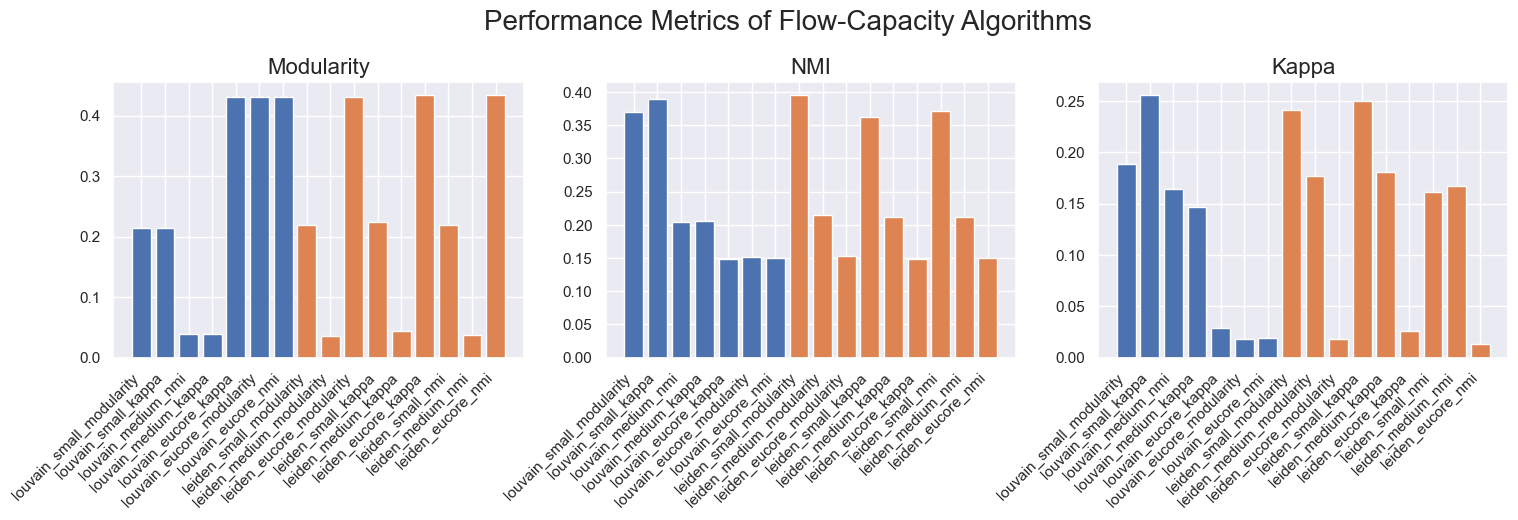

In [352]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

# modularity
ax[0].bar([key for key in res_flow_capacity], modularities, color=colors)
ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[0].set_title("Modularity", fontsize=16)


# nmi
ax[1].bar([key for key in res_flow_capacity], nmis, color=colors)
ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[1].set_title("NMI", fontsize=16)

# kappa
ax[2].bar([key for key in res_flow_capacity], kappas, color=colors)
ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[2].set_title("Kappa", fontsize=16)

plt.subplots_adjust(top=0.8)
plt.suptitle("Performance Metrics of Flow-Capacity Algorithms", fontsize=20)